# Load Dataset

In [7]:
import minari
import pickle
import numpy as np
import collections
import minari


def _load_dataset_minari(env_name, dataset = None): # jensk

    trajectories = dataset
    states, traj_lens, returns = [], [], []
    if 'pointmaze' in env_name :
        # re-label observation. (achieved_goal, desired_goal) -> observation
        print("re-label observation. (achieved_goal, desired_goal) -> observation")
        for path in trajectories :
            achieved_goal = path['observations']['achieved_goal'][1:]
            desired_goal = path['observations']['desired_goal'][1:]
            observation = np.concatenate([achieved_goal, desired_goal], axis=1)
            path['observations'] = observation

    for path in trajectories:
        states.append(path["observations"])
        traj_lens.append(len(path["observations"]))
        returns.append(path["rewards"].sum())
        # for pointmaze
    traj_lens, returns = np.array(traj_lens), np.array(returns)
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
    num_timesteps = sum(traj_lens)

    print("=" * 50)
    print(f"Starting new experiment: {env_name}")
    print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
    print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
    print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
    print(f"Average length: {np.mean(traj_lens):.2f}, std: {np.std(traj_lens):.2f}")
    print(f"Max length: {np.max(traj_lens):.2f}, min: {np.min(traj_lens):.2f}")
    print("=" * 50)

    sorted_inds = np.argsort(returns)  # lowest to highest
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:]

    trajectories = [trajectories[ii] for ii in sorted_inds]
    return trajectories, state_mean, state_std

def _load_dataset_01(env_name) :

    offline_trajs, state_mean, state_std = _load_dataset_minari(env_name, dataset)
    # create ['K'] length trajectories with initial state and final state
    offline_trajs_01 = []
    for traj in offline_trajs:
        traj_len = len(traj["observations"])
        # divide the trajectory into K length. get index of K length
        if traj_len < variant["K"] :
            continue 
        index = np.linspace(0, traj_len - 1, variant["K"]).astype(int)
        #print(f"traj len: {traj_len}, index : {index}")
        # get the state and action of the index
        # get the initial action and final action
        for key in traj.keys() :
            if key in ['id', 'total_timesteps', 'seed' ] :
                continue
            traj[key] = traj[key][index]
        offline_trajs_01.append(traj)
    
    print(f"offline_trajs_01 : {len(offline_trajs_01)}")
    return offline_trajs_01, state_mean, state_std
    
    


In [8]:

env_name = "pointmaze-umaze-v1"
actual_env_name = 'PointMaze_Umaze-v3'
dataset = minari.load_dataset("pointmaze-umaze-v1")
dataset = dataset._data.get_episodes(range(0,1000))

variant = {}
variant['K'] = 20

data, state_mean, state_std = _load_dataset_01('pointmaze-umaze-v1')

re-label observation. (achieved_goal, desired_goal) -> observation
Starting new experiment: pointmaze-umaze-v1
1000 trajectories, 73537 timesteps found
Average return: 1.00, std: 0.00
Max return: 1.00, min: 1.00
Average length: 73.54, std: 43.50
Max length: 183.00, min: 1.00
offline_trajs_01 : 885


# Load Trained model01

In [9]:
from decision_transformer.models.decision_transformer import DecisionTransformer01
import torch
from pathlib import Path
import random
import numpy as np
MAX_EPISODE_LEN = 1000

variant = {
    "seed": 10,
    "env": "PointMaze_Umaze-v3",
    "K": 20,
    "embed_dim": 512,
    "n_layer": 4,
    "n_head": 4,
    "activation_function": "relu",
    "dropout": 0.1,
    "eval_context_length": 5,
    "ordering": 0,
    "eval_rtg": 3600,
    "num_eval_episodes": 10,
    "init_temperature": 0.1,
    "batch_size": 256,
    "learning_rate": 1e-4,
    "weight_decay": 5e-4,
    "warmup_steps": 10000,
    "max_pretrain_iters": 1,
    "num_updates_per_pretrain_iter": 5000,
    "max_online_iters": 1500,
    "online_rtg": 7200,
    "num_online_rollouts": 1,
    "replay_size": 1000,
    "num_updates_per_online_iter": 300,
    "eval_interval": 10,
    "device": "cuda",
    "log_to_tb": True,
    "save_dir": "./exp",
    "exp_name": "default",
    "tags": "model:01"
}

device = 'cuda'

model = DecisionTransformer01(
    state_dim= 4,
    state_range= [-2,2],
    max_length=variant["K"],
    eval_context_length=variant["eval_context_length"],
    max_ep_len=MAX_EPISODE_LEN,
    hidden_size=variant["embed_dim"],
    n_layer=variant["n_layer"],
    n_head=variant["n_head"],
    n_inner=4 * variant["embed_dim"],
    activation_function=variant["activation_function"],
    n_positions=1024,
    resid_pdrop=variant["dropout"],
    attn_pdrop=variant["dropout"],
    stochastic_policy=True,
    ordering=variant["ordering"],
    init_temperature=variant["init_temperature"],
    target_entropy= -4,
).to(device=device)


path_prefix = "./exp/2023.1.5/120115-default"
if Path(f"{path_prefix}/model.pt").exists():
    with open(f"{path_prefix}/model.pt", "rb") as f:
        checkpoint = torch.load(f)
    model.load_state_dict(checkpoint["model_state_dict"])
    #self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    #self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    #self.log_temperature_optimizer.load_state_dict(
    #    checkpoint["log_temperature_optimizer_state_dict"]
    #)
    #self.pretrain_iter = checkpoint["pretrain_iter"]
    #self.online_iter = checkpoint["online_iter"]
    #self.total_transitions_sampled = checkpoint["total_transitions_sampled"]
    np.random.set_state(checkpoint["np"])
    random.setstate(checkpoint["python"])
    torch.set_rng_state(checkpoint["pytorch"])
    print(f"Model loaded at {path_prefix}/model.pt")
#model.load_state_dict(torch.load('decision_transformer_01.pt'))

In [18]:


def convert_obs_type(obs, device) :
    # check obs batch size
    # handling (seq, state_dim) -> (1, seq, state_dim)
    if len(obs.shape) == 2 :
        obs = obs.reshape(1, -1, obs.shape[-1])
    elif len(obs.shape) == 1 :
        # handling (state_dim) -> (1, 1, state_dim)
        obs = obs.reshape(1, 1, obs.shape[-1])
    elif len(obs.shape) == 3 :
        # handling (batch_size, seq, state_dim) -> (batch_size, seq, state_dim)
        pass
    else :
        raise ValueError("obs shape is not valid")
    return torch.tensor(obs).float().to(device)

def regularize_obs(obs, model:DecisionTransformer01) :
    state_mean = 0
    state_std = 2
    ret = (obs - state_mean) / state_std
    return ret
def unregularize_obs(obs, model:DecisionTransformer01) :
    state_mean = 0
    state_std = 2
    obs = obs * state_std + state_mean
    return obs


def predict_K_sequence(batch_obs, model:DecisionTransformer01):
    # check model is where device. if model has no attribute device, check the first parameter of the model
    if hasattr(model, 'device') :
        device = model.device
    else :
        device = model.transformer.device
        
    obs = convert_obs_type(batch_obs, device)
    state_dim = obs.shape[-1]

    print(f"before regularize : {obs}")
    processed_obs = regularize_obs(obs, model)
    print(f"after regularize : {processed_obs}")
    desired_goal = processed_obs[:, -1, state_dim//2:]

    K = 5#model.max_length
    print(f"K : {K}")
    use_mean = True
    num_envs = 1
    print(f"state_dim : {state_dim}, desired_goal : {desired_goal}")
    while processed_obs.shape[1] < K :
        print(f'input : {processed_obs}')
        timesteps = torch.tensor([0] * 1, device=device, dtype=torch.long).reshape(1, -1).to(device)
        last_state_dist = model.get_predictions(processed_obs, timesteps)
        # the return action is a SquashNormal distribution
        state = last_state_dist.sample().reshape(1, -1, state_dim)[:, -1]
        if use_mean:
            state = last_state_dist.mean.reshape(num_envs, -1, state_dim)[:, -1]
        state = state.clamp(*model.state_range)
        state = convert_obs_type(state, device)
        # set desired_goal
        state[:,:, state_dim//2:] = desired_goal
        processed_obs = torch.cat([state,processed_obs], dim=1)
        timesteps += 1
    unregularized_obs = unregularize_obs(processed_obs, model)
    print(f"final result: obs: {unregularized_obs}")
    return unregularized_obs

batch_obs = data[2]['observations'][0]     
predict_K_sequence(batch_obs, model)



before regularize : tensor([[[ 0.1881, -0.9346, -0.8327,  0.8794]]], device='cuda:0')
after regularize : tensor([[[ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[-0.4163,  0.4397]], device='cuda:0')
input : tensor([[[ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
input : tensor([[[-0.2907, -0.8038, -0.4163,  0.4397],
         [ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
input : tensor([[[ 0.2615, -0.3906, -0.4163,  0.4397],
         [-0.2907, -0.8038, -0.4163,  0.4397],
         [ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
input : tensor([[[-0.0912, -0.8844, -0.4163,  0.4397],
         [ 0.2615, -0.3906, -0.4163,  0.4397],
         [-0.2907, -0.8038, -0.4163,  0.4397],
         [ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
final result: obs: tensor([[[-0.9165, -1.7846, -0.8327,  0.8794],
         [-0.1824, -1.7688, -0.8327,  0.8794],
         [ 0.5231, -0.7813, -0.8327,  0.8794],
         

/tmp/ipykernel_981/3481979145.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs).float().to(device)


tensor([[[-0.9165, -1.7846, -0.8327,  0.8794],
         [-0.1824, -1.7688, -0.8327,  0.8794],
         [ 0.5231, -0.7813, -0.8327,  0.8794],
         [-0.5814, -1.6076, -0.8327,  0.8794],
         [ 0.1881, -0.9346, -0.8327,  0.8794]]], device='cuda:0')

885
before regularize : tensor([[[-0.7951, -1.0287,  0.8800,  0.7912]]], device='cuda:0')
after regularize : tensor([[[-0.3975, -0.5144,  0.4400,  0.3956]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[0.4400, 0.3956]], device='cuda:0')
input : tensor([[[-0.3975, -0.5144,  0.4400,  0.3956]]], device='cuda:0')
input : tensor([[[-0.7933, -0.9567,  0.4400,  0.3956],
         [-0.3975, -0.5144,  0.4400,  0.3956]]], device='cuda:0')
input : tensor([[[-0.7213, -0.9164,  0.4400,  0.3956],
         [-0.7933, -0.9567,  0.4400,  0.3956],
         [-0.3975, -0.5144,  0.4400,  0.3956]]], device='cuda:0')
input : tensor([[[-0.5997, -0.9722,  0.4400,  0.3956],
         [-0.7213, -0.9164,  0.4400,  0.3956],
         [-0.7933, -0.9567,  0.4400,  0.3956],
         [-0.3975, -0.5144,  0.4400,  0.3956]]], device='cuda:0')
final result: obs: tensor([[[-1.5244, -1.8968,  0.8800,  0.7912],
         [-1.1993, -1.9444,  0.8800,  0.7912],
         [-1.4426, -1.8328,  0.8800,  0.7912],
       

/tmp/ipykernel_981/3481979145.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs).float().to(device)


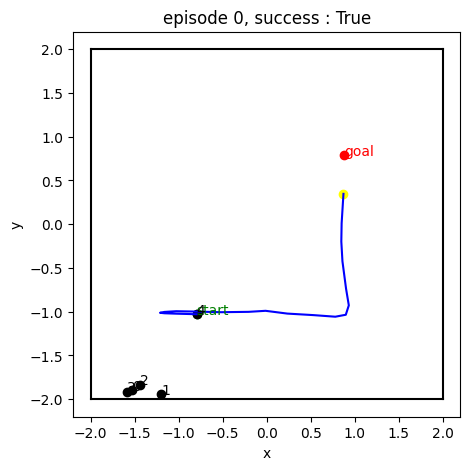

episode done at 0
before regularize : tensor([[[ 0.8733,  0.3955,  0.0923, -0.8737]]], device='cuda:0')
after regularize : tensor([[[ 0.4366,  0.1977,  0.0461, -0.4369]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[ 0.0461, -0.4369]], device='cuda:0')
input : tensor([[[ 0.4366,  0.1977,  0.0461, -0.4369]]], device='cuda:0')
input : tensor([[[-0.8413, -0.4647,  0.0461, -0.4369],
         [ 0.4366,  0.1977,  0.0461, -0.4369]]], device='cuda:0')
input : tensor([[[-0.9832, -0.5218,  0.0461, -0.4369],
         [-0.8413, -0.4647,  0.0461, -0.4369],
         [ 0.4366,  0.1977,  0.0461, -0.4369]]], device='cuda:0')
input : tensor([[[-0.9099, -0.6301,  0.0461, -0.4369],
         [-0.9832, -0.5218,  0.0461, -0.4369],
         [-0.8413, -0.4647,  0.0461, -0.4369],
         [ 0.4366,  0.1977,  0.0461, -0.4369]]], device='cuda:0')
final result: obs: tensor([[[-1.9171, -1.3198,  0.0923, -0.8737],
         [-1.8198, -1.2602,  0.0923, -0.8737],
         [-1.9664, -1.0436,  0.0923, -

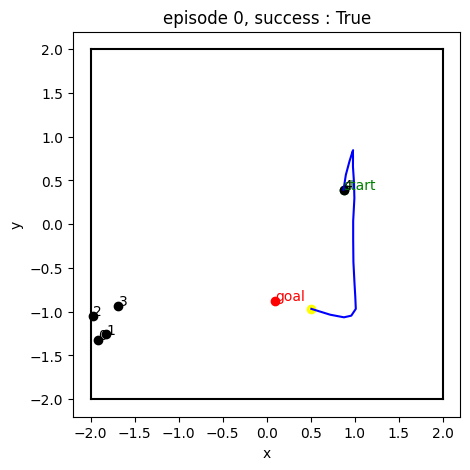

episode done at 0
before regularize : tensor([[[ 0.1881, -0.9346, -0.8327,  0.8794]]], device='cuda:0')
after regularize : tensor([[[ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[-0.4163,  0.4397]], device='cuda:0')
input : tensor([[[ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
input : tensor([[[-0.3238, -0.8801, -0.4163,  0.4397],
         [ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
input : tensor([[[-0.1851, -0.9028, -0.4163,  0.4397],
         [-0.3238, -0.8801, -0.4163,  0.4397],
         [ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
input : tensor([[[-0.5743, -0.8853, -0.4163,  0.4397],
         [-0.1851, -0.9028, -0.4163,  0.4397],
         [-0.3238, -0.8801, -0.4163,  0.4397],
         [ 0.0941, -0.4673, -0.4163,  0.4397]]], device='cuda:0')
final result: obs: tensor([[[ 0.0809, -1.7998, -0.8327,  0.8794],
         [-1.1486, -1.7706, -0.8327,  0.8794],
         [-0.3702, -1.8057, -0.8327,  

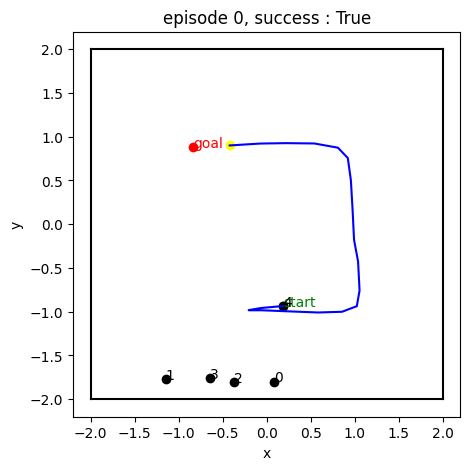

episode done at 0
before regularize : tensor([[[-0.4639,  0.8989, -0.0949, -0.8457]]], device='cuda:0')
after regularize : tensor([[[-0.2319,  0.4494, -0.0475, -0.4228]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[-0.0475, -0.4228]], device='cuda:0')
input : tensor([[[-0.2319,  0.4494, -0.0475, -0.4228]]], device='cuda:0')
input : tensor([[[-0.9128,  0.1532, -0.0475, -0.4228],
         [-0.2319,  0.4494, -0.0475, -0.4228]]], device='cuda:0')
input : tensor([[[-0.9448, -0.3967, -0.0475, -0.4228],
         [-0.9128,  0.1532, -0.0475, -0.4228],
         [-0.2319,  0.4494, -0.0475, -0.4228]]], device='cuda:0')
input : tensor([[[-0.9389, -0.0743, -0.0475, -0.4228],
         [-0.9448, -0.3967, -0.0475, -0.4228],
         [-0.9128,  0.1532, -0.0475, -0.4228],
         [-0.2319,  0.4494, -0.0475, -0.4228]]], device='cuda:0')
final result: obs: tensor([[[-1.8637, -0.1317, -0.0949, -0.8457],
         [-1.8778, -0.1487, -0.0949, -0.8457],
         [-1.8896, -0.7934, -0.0949, -

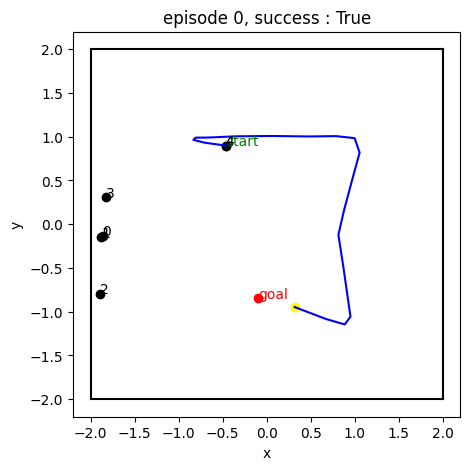

episode done at 0
before regularize : tensor([[[ 0.2732, -0.9337, -0.7744,  0.7878]]], device='cuda:0')
after regularize : tensor([[[ 0.1366, -0.4668, -0.3872,  0.3939]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[-0.3872,  0.3939]], device='cuda:0')
input : tensor([[[ 0.1366, -0.4668, -0.3872,  0.3939]]], device='cuda:0')
input : tensor([[[ 0.1698, -0.9299, -0.3872,  0.3939],
         [ 0.1366, -0.4668, -0.3872,  0.3939]]], device='cuda:0')
input : tensor([[[ 0.2260, -0.9191, -0.3872,  0.3939],
         [ 0.1698, -0.9299, -0.3872,  0.3939],
         [ 0.1366, -0.4668, -0.3872,  0.3939]]], device='cuda:0')
input : tensor([[[ 0.4617, -0.9048, -0.3872,  0.3939],
         [ 0.2260, -0.9191, -0.3872,  0.3939],
         [ 0.1698, -0.9299, -0.3872,  0.3939],
         [ 0.1366, -0.4668, -0.3872,  0.3939]]], device='cuda:0')
final result: obs: tensor([[[-0.5771, -1.9110, -0.7744,  0.7878],
         [ 0.9233, -1.8096, -0.7744,  0.7878],
         [ 0.4520, -1.8382, -0.7744,  

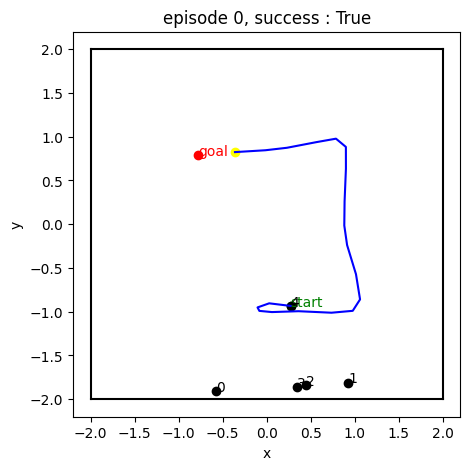

episode done at 0
before regularize : tensor([[[-0.4074,  0.8203, -0.0197, -1.0209]]], device='cuda:0')
after regularize : tensor([[[-0.2037,  0.4102, -0.0099, -0.5104]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[-0.0099, -0.5104]], device='cuda:0')
input : tensor([[[-0.2037,  0.4102, -0.0099, -0.5104]]], device='cuda:0')
input : tensor([[[-0.9689,  0.2315, -0.0099, -0.5104],
         [-0.2037,  0.4102, -0.0099, -0.5104]]], device='cuda:0')
input : tensor([[[-0.9865, -0.0786, -0.0099, -0.5104],
         [-0.9689,  0.2315, -0.0099, -0.5104],
         [-0.2037,  0.4102, -0.0099, -0.5104]]], device='cuda:0')
input : tensor([[[-0.9116, -0.1286, -0.0099, -0.5104],
         [-0.9865, -0.0786, -0.0099, -0.5104],
         [-0.9689,  0.2315, -0.0099, -0.5104],
         [-0.2037,  0.4102, -0.0099, -0.5104]]], device='cuda:0')
final result: obs: tensor([[[-1.9425,  0.6297, -0.0197, -1.0209],
         [-1.8231, -0.2571, -0.0197, -1.0209],
         [-1.9730, -0.1572, -0.0197, -

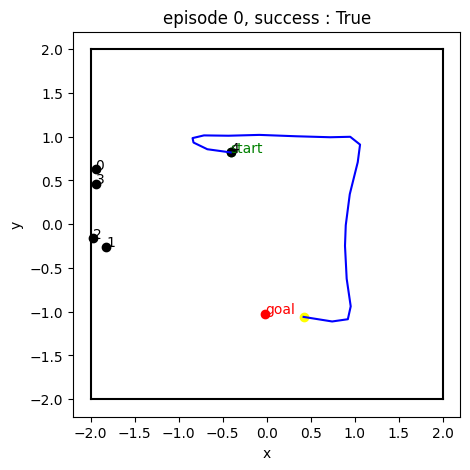

episode done at 0
before regularize : tensor([[[ 0.3266, -1.0505,  0.8142, -0.1207]]], device='cuda:0')
after regularize : tensor([[[ 0.1633, -0.5253,  0.4071, -0.0604]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[ 0.4071, -0.0604]], device='cuda:0')
input : tensor([[[ 0.1633, -0.5253,  0.4071, -0.0604]]], device='cuda:0')
input : tensor([[[-0.8192, -0.9543,  0.4071, -0.0604],
         [ 0.1633, -0.5253,  0.4071, -0.0604]]], device='cuda:0')
input : tensor([[[-0.8050, -0.8005,  0.4071, -0.0604],
         [-0.8192, -0.9543,  0.4071, -0.0604],
         [ 0.1633, -0.5253,  0.4071, -0.0604]]], device='cuda:0')
input : tensor([[[-0.8518, -0.7575,  0.4071, -0.0604],
         [-0.8050, -0.8005,  0.4071, -0.0604],
         [-0.8192, -0.9543,  0.4071, -0.0604],
         [ 0.1633, -0.5253,  0.4071, -0.0604]]], device='cuda:0')
final result: obs: tensor([[[-1.7352, -1.8899,  0.8142, -0.1207],
         [-1.7036, -1.5151,  0.8142, -0.1207],
         [-1.6100, -1.6009,  0.8142, -

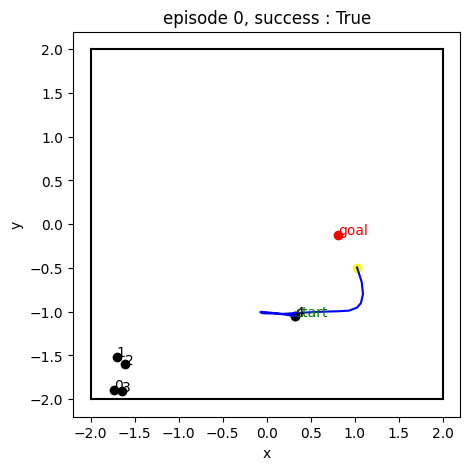

episode done at 0
before regularize : tensor([[[ 1.0095, -0.4561,  1.0984, -1.2471]]], device='cuda:0')
after regularize : tensor([[[ 0.5048, -0.2281,  0.5492, -0.6235]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[ 0.5492, -0.6235]], device='cuda:0')
input : tensor([[[ 0.5048, -0.2281,  0.5492, -0.6235]]], device='cuda:0')
input : tensor([[[-0.7281, -0.8800,  0.5492, -0.6235],
         [ 0.5048, -0.2281,  0.5492, -0.6235]]], device='cuda:0')
input : tensor([[[-0.9524, -0.6815,  0.5492, -0.6235],
         [-0.7281, -0.8800,  0.5492, -0.6235],
         [ 0.5048, -0.2281,  0.5492, -0.6235]]], device='cuda:0')
input : tensor([[[-0.9566, -0.7716,  0.5492, -0.6235],
         [-0.9524, -0.6815,  0.5492, -0.6235],
         [-0.7281, -0.8800,  0.5492, -0.6235],
         [ 0.5048, -0.2281,  0.5492, -0.6235]]], device='cuda:0')
final result: obs: tensor([[[-1.9726, -0.8879,  1.0984, -1.2471],
         [-1.9132, -1.5431,  1.0984, -1.2471],
         [-1.9048, -1.3629,  1.0984, -

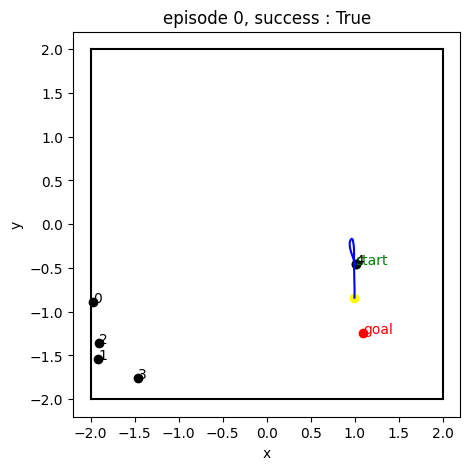

episode done at 0
before regularize : tensor([[[ 0.9989, -0.8693, -0.8799, -1.0690]]], device='cuda:0')
after regularize : tensor([[[ 0.4994, -0.4347, -0.4399, -0.5345]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[-0.4399, -0.5345]], device='cuda:0')
input : tensor([[[ 0.4994, -0.4347, -0.4399, -0.5345]]], device='cuda:0')
input : tensor([[[-0.8458, -0.6273, -0.4399, -0.5345],
         [ 0.4994, -0.4347, -0.4399, -0.5345]]], device='cuda:0')
input : tensor([[[-0.8786, -0.5288, -0.4399, -0.5345],
         [-0.8458, -0.6273, -0.4399, -0.5345],
         [ 0.4994, -0.4347, -0.4399, -0.5345]]], device='cuda:0')
input : tensor([[[-0.7747, -0.3930, -0.4399, -0.5345],
         [-0.8786, -0.5288, -0.4399, -0.5345],
         [-0.8458, -0.6273, -0.4399, -0.5345],
         [ 0.4994, -0.4347, -0.4399, -0.5345]]], device='cuda:0')
final result: obs: tensor([[[-1.5418, -0.7089, -0.8799, -1.0690],
         [-1.5494, -0.7860, -0.8799, -1.0690],
         [-1.7572, -1.0575, -0.8799, -

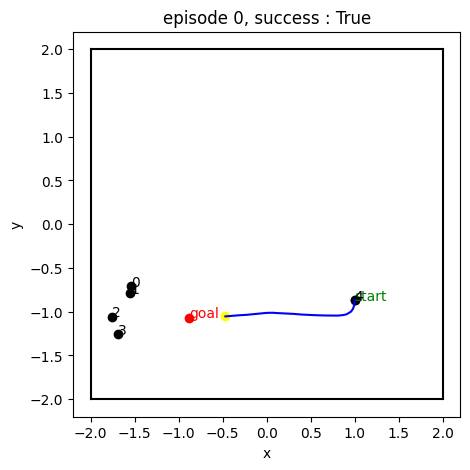

episode done at 0
before regularize : tensor([[[-0.5169, -1.0573,  1.0759,  1.1415]]], device='cuda:0')
after regularize : tensor([[[-0.2584, -0.5286,  0.5379,  0.5707]]], device='cuda:0')
K : 5
state_dim : 4, desired_goal : tensor([[0.5379, 0.5707]], device='cuda:0')
input : tensor([[[-0.2584, -0.5286,  0.5379,  0.5707]]], device='cuda:0')
input : tensor([[[-0.3228, -0.9623,  0.5379,  0.5707],
         [-0.2584, -0.5286,  0.5379,  0.5707]]], device='cuda:0')
input : tensor([[[-0.5721, -0.9401,  0.5379,  0.5707],
         [-0.3228, -0.9623,  0.5379,  0.5707],
         [-0.2584, -0.5286,  0.5379,  0.5707]]], device='cuda:0')
input : tensor([[[-0.4594, -0.9190,  0.5379,  0.5707],
         [-0.5721, -0.9401,  0.5379,  0.5707],
         [-0.3228, -0.9623,  0.5379,  0.5707],
         [-0.2584, -0.5286,  0.5379,  0.5707]]], device='cuda:0')
final result: obs: tensor([[[-1.2025, -1.9402,  1.0759,  1.1415],
         [-0.9187, -1.8380,  1.0759,  1.1415],
         [-1.1441, -1.8801,  1.0759,  1.

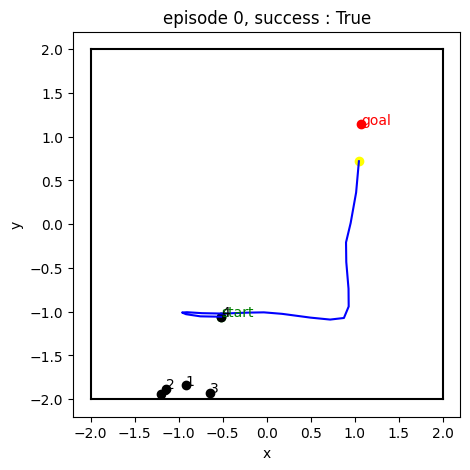

episode done at 0


In [28]:
# plot map with matplotlib
import matplotlib.pyplot as plt

map_size = ((-2,2),(-2,2)) # x, y


def init_figure() :
    # draw outline 
    plt.figure(figsize=(5,5))
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][0], map_size[1][0]], color='black')
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][1], map_size[1][1]], color='black')
    plt.plot([map_size[0][0], map_size[0][0]], [map_size[1][0], map_size[1][1]], color='black')
    plt.plot([map_size[0][1], map_size[0][1]], [map_size[1][0], map_size[1][1]], color='black')
    # set figure size


def plot_trajectory(trajectory, color='blue'):
    # plot trajectory
    plt.plot(trajectory[:,0], trajectory[:,1], color=color)

start_i = 0
n_epi = 10
episode_frames = []
episode_agent_states = []
episode_goals = []
episode_start = start_i
episode_done = False

print(len(data))
for i in range (start_i, start_i + n_epi) :
    achieved_goal = data[i]['observations'][:,:2]
    desired_goals = data[i]['observations'][:,-2:]
    #print(data[i]['observations'].shape)
    # predict K sequence
    #print(data[i]['observations'])
    model01_input = data[i]['observations'][0]
    model01_output = predict_K_sequence(model01_input, model).detach().cpu().numpy()
    # reshape model01_output, crop only achived_goal
    model01_output = model01_output[:, :, :2]
    model01_output = model01_output.reshape(-1, 2)
    print(model01_output.shape)
    
    
    # draw trajectory
    init_figure()
    plot_trajectory(np.array(achieved_goal))
    # draw goals
    plt.scatter(desired_goals[-1][0], desired_goals[-1][1], color='red')
    # draw start
    plt.scatter(achieved_goal[0][0], achieved_goal[0][1], color='green')
    # draw end
    plt.scatter(achieved_goal[-1][0], achieved_goal[-1][1], color='yellow')
    # add labels that show what meaning of green, yellow, red
    plt.text(achieved_goal[0][0], achieved_goal[0][1], 'start', color='green')
    #plt.text(episode_agent_states[-1][0], episode_agent_states[-1][1], 'end', color='yellow')
    plt.text(desired_goals[-1][0], desired_goals[-1][1], 'goal', color='red')
    
    # scatter model01_output
    for i in range(len(model01_output)-1,-1,-1) :
        print(i)
        plt.scatter(model01_output[i][0], model01_output[i][1], color='black')
        plt.text(model01_output[i][0], model01_output[i][1], f'{i}', color='black')
    
    plt.title(f'episode {i}, success : {data[i]["rewards"].any()}')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()
    episode_agent_states = []
    episode_goals = []
    episode_done = False
    print('episode done at', i)


In [6]:
data[0]['observations'].shape

(20, 4)